# Indice
* [Il Dataset](#cap1)
* [Scopo](#cap2)
  * [Suggerire membri del cast o della troupe](#cap2.1)
  * [Predirre gli incassi](#cap2.2)
* [Soluzioni Proposte](#cap3)
  * [Suggerire membri del cast o della troupe](#cap3.1)
  * [Predirre gli incassi](#cap3.2)
* [Risultati e confronti](#cap4)

In [1]:
import pandas as pd
import numpy as np
import ast

from tqdm import tqdm

# Association rules
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# SKlearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error,explained_variance_score,r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer

# lightgbm
import lightgbm as lgb

# Tensorflow
import tensorflow as tf
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

# Matplot
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Bokeh area
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import HoverTool
output_notebook()

Loading BokehJS ...

# Il Dataset <a class="anchor" id="cap1"></a>
Il dataset è reperibile su kaggle a questo [link](https://www.kaggle.com/c/tmdb-box-office-prediction).

In [2]:
train = pd.read_csv('../input/train.csv')
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
train.head(1)

id                              belongs_to_collection    budget  \
0   1  [{'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U...  14000000   

                           genres homepage    imdb_id original_language  \
0  [{'id': 35, 'name': 'Comedy'}]      NaN  tt2637294                en   

           original_title                                           overview  \
0  Hot Tub Time Machine 2  When Lou, who has become the "father of the In...   

   popularity  ... release_date runtime  \
0    6.575393  ...      2/20/15    93.0   

                           spoken_languages    status  \
0  [{'name': 'English', 'iso_639_1': 'en'}]  Released   

                                             tagline                   title  \
0  The Laws of Space and Time are About to be Vio...  Hot Tub Time Machine 2   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   

                                                cast  \
0  [{'cast_id': 4, 'gender': 2, 'id': 52997, 'pro...   

                                                crew   revenue  
0  [{'profile_path': None, 'gender': 0, 'id': 144...  12314651  

[1 rows x 23 columns]

Il dataset contiene svariati campi. Alcuni di questi: 'belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast' e 'crew' sono campi complessi e quindi dopo aver letto il dataframe dobbiamo effettuare delle trasformazioni.

* __belongs_to_collection__: è una collezione di elementi che contengono il filone di apparteneza del film, per esempio: 'Pokemon Collection' o 'Rambo Collection' o ancora 'James Bond Collection'. Nonostante questo campio possa essere multiplo in questo caso è presente o un solo dato oppure nessuno.


In [3]:
counts_values = train['belongs_to_collection'].apply(lambda x: 'size_%d' % len(x) if x != {} else 'empty').value_counts()
x = []
y = []
for i, v in counts_values.items():
    x.append(str(i))
    y.append(v)
p = figure(x_range=x, plot_height=250, title="Count of null or full")
p.vbar(x=x, top=y, width=0.9)
p.add_tools(HoverTool(tooltips=[('value', '@top')]))
show(p)

* __budget__: questa colonna contiene il budget utilizzato dai produttori per realizzare il film. Varia tra 0 e $3,8 \cdot 10^8$ con una media di $2,2 \cdot 10^7$.

In [4]:
budgets = train['budget']
mean_value = np.mean(budgets)
max_value = np.max(budgets)
min_value = np.min(budgets)
median_value = np.median(budgets)
x = ['min', 'median','mean', 'max']
y = [min_value, median_value, mean_value, max_value]
p = figure(x_range=x, plot_height=250, title="Value analysys")
p.vbar(x=x, top=y, width=0.9)
p.add_tools(HoverTool(tooltips=[('value', '@top')]))
show(p)

* __genres__: è una collezioni di generi a cui il film appartiene, per esemio Drammatico oppure Giallo. Il numero di generi varia da 0 a 7 con gli estremi molto meno occorrenti.

In [5]:
number_of_genres_for_film = train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()
number_of_genres_for_film.sort_index(inplace=True)
x = []
y = []
for i, v in number_of_genres_for_film.items():
    x.append(str(i))
    y.append(v)
p = figure(x_range=x, plot_height=250, title="Count of genres in films")
p.vbar(x=x, top=y, width=0.9)
p.add_tools(HoverTool(tooltips=[('value', '@top')]))
show(p)

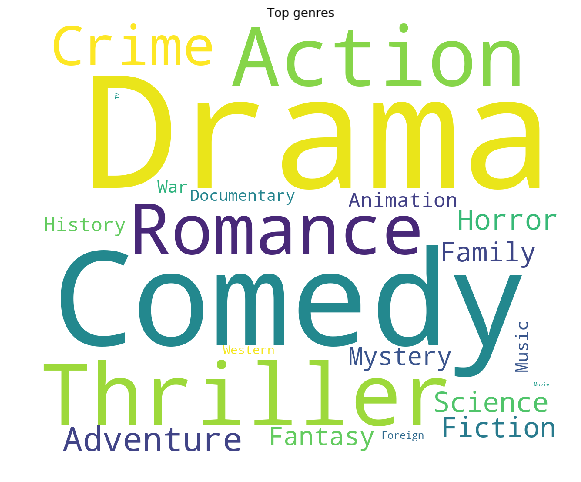

In [6]:
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

* __homepage__: è un link alla homepage del film, tutavia molti non la possiedono.

In [7]:
hp = train['homepage'].apply(lambda x: 'Have HP' if not isinstance(x, float) else 'NaN').value_counts()
x = []
y = []
for i, v in hp.items():
    x.append(str(i))
    y.append(v)
p = figure(x_range=x, plot_height=250, title="Homepage Count")
p.vbar(x=x, top=y, width=0.9)
p.add_tools(HoverTool(tooltips=[('value', '@top')]))
show(p)

* __poster_path__: è un link al poster se è presente online.

In [8]:
hp = train['poster_path'].apply(lambda x: 'Have poster' if not isinstance(x, float) else 'NaN').value_counts()
x = []
y = []
for i, v in hp.items():
    x.append(str(i))
    y.append(v)
p = figure(x_range=x, plot_height=250, title="Poster Count")
p.vbar(x=x, top=y, width=0.9)
p.add_tools(HoverTool(tooltips=[('value', '@top')]))
show(p)

* __status__: ci dice se il film è già stato distribuito oppure è stato solo annunciato. Tuttavia non sembra un informazione interessante dato che tutti i film preseti nel dataset sono stati già distribuiti.

In [9]:
status = train['status'].value_counts()
status.sort_index(inplace=True)
x = []
y = []
for i, v in status.items():
    x.append(str(i))
    y.append(v)
p = figure(x_range=x, plot_height=250, title="Count of status")
p.vbar(x=x, top=y, width=0.9)
p.add_tools(HoverTool(tooltips=[('value', '@top')]))
show(p)

* __revenue__: valore che rappresenta gli incassi. Anche questo valore come gli altri è molto variabile

In [10]:
revenue = train['revenue'].fillna(0.0)
mean_value = np.mean(revenue)
max_value = np.max(revenue)
min_value = np.min(revenue)
median_value = np.median(revenue) 
x = ['min', 'median','mean', 'max']
y = [min_value, median_value, mean_value, max_value]
p = figure(x_range=x, plot_height=250, title="Revenue analysys")
p.vbar(x=x, top=y, width=0.9)
p.add_tools(HoverTool(tooltips=[('value', '@top')]))
show(p)

* __original_language__: rappresenta la lingua originale in cui è stato girato il film.
* __spoken_languages__: una lista di linguaggi che vengono parlati nel film.
* __original_title__: contiene il titolo originale, nella lingua originale del film.
* __title__: contiene il titolo del film in lingua inglese.
* __tagline__: è una frase breve e diretta che riassume in modo istantaneo il contenuto del film.
* __overview__: contiene un riassunto del film in lingua inglese.
* __Keywords__: sono delle parole chiave che vengono aggiunte ai dati del film, posseggono anche un id.
* __release_date__: contiene la data di uscita del film.
* __cast__: contiene la lista di attori che hanno partecipato al film.
* __crew__: contiene la lista delle personi presenti nella troupe cinematografica.
* __production_companies__: elenco di aziende che hanno finanziato la produzione del film.
* __production_countries__: elenco di stati in cui è stato girato il film.
* __runtime__: valore che contiene la durata del film.
* __popularity__: valore che indica la popolarità del film.
* __imdb_id__: è l'id della tupla nel database.

# Scopo <a class="anchor" id="cap2"></a>

Abbiamo due obbiettivi:
* consigliare ad un regista dato un elemento del cast o della crew quali altri elementi conviene selezionare da aggiungere nel cast o nella troupe, basandosi sul fatto che lavorano spesso insieme e quindi faranno risparmiare tempo e si potrà garantire un prodotto migliore. Si può utilizzare questo metodo anche per consigliare ad un utente un film con cast e crew che spesso si trovano in film che ha già visto. 
* predirre gli incassi del film

## Suggerire membri del cast o della troupe <a class="anchor" id="cap2.1"></a>

L'implementazione viene effettuata utilizzando le regole di associazione. Si uniranno gli attori e i membri della troupe in un insieme. Dato che esistono membri che hanno partecipato ad un solo film e non possono esistere regole per loro, ma anche chi ha partecipato a pochi film insieme potrebbero non essere rilevanti, così si selezioneranno solo i membri che compaiono più spesso. Dopo di che si procederà con la creazione degli elementi frequenti tramite il metodo apriori e poi si costruiranno le regole di associazione.  
In particolare si è scartata la soluzione di utilizzare solo gli attori inquanto non venivano generati molti elementi frequenti.

## Predirre gli incassi <a class="anchor" id="cap2.2"></a>

Il risultato viene implementato utilizzado reti neurali e confrontandolo con il risultato migliore di kaggle che utilizza
un light gradient boosting machine regressor.
Viene effettuata una feature selection che ha dato i risultati migliori e vengono addestrate delle reti neurali.
Poi il risultato viene confrontato con quello di kaggle utilizzando la sua feature selection ed estraction.

# Soluzioni Proposte <a class="anchor" id="cap3"></a>

## Suggerire membri del cast o della troupe <a class="anchor" id="cap3.1"></a>

Seleziono un certo numero di attori presi tra quelli che più partecipano ai film nel dataset.

In [11]:
SELECTED = 3000
cast_and_crew = []
with tqdm(total=len(train)) as pbar:
    for i, row in train.iterrows():
        pbar.update(1)
        cast = row['cast']
        for cp in cast:
            cast_and_crew.append('(%d) %s' % (cp['id'], cp['name']))
        crew = row['crew']
        for cp in crew:
            cast_and_crew.append('(%d) %s' % (cp['id'], cp['name']))
comp = pd.Series(cast_and_crew).value_counts()
comp.sort_index(inplace=False)
comp = comp[:SELECTED]
cast_and_crew_set = [ worker for worker, _ in comp.items()]

100%|██████████| 3000/3000 [00:00<00:00, 3422.22it/s]


Creo l'insieme dei vari membri della troupe e del cast.

In [12]:
basket = []
complete_worker_set = set()

with tqdm(total=len(train)) as pbar:
    for i, row in train.iterrows():
        pbar.update(1)
        workers = []
        crew = row['crew']
        for cs in crew:
            worker = '(%d) %s' % (cs['id'], cs['name'])
            if worker in cast_and_crew_set:
                workers.append(worker)
        cast = row['cast']
        for cs in cast:
            worker = '(%d) %s' % (cs['id'], cs['name'])
            if worker in cast_and_crew_set:
                workers.append(worker)
        if len(workers) > 2: # remove all film that have only 2 actors
            complete_worker_set.update(workers)
            basket.append(workers)

100%|██████████| 3000/3000 [00:08<00:00, 343.13it/s]


Creo i vari carrelli.

In [13]:
columns = list(complete_worker_set)
data = { c: [] for c in columns }

with tqdm(total=len(basket)) as pbar:
    for b in basket:
        pbar.update(1)
        for c in columns:
            if c in b:
                data[c].append(1)
            else:
                data[c].append(0)

basket_sets = pd.DataFrame(data,columns=columns)

100%|██████████| 2231/2231 [00:03<00:00, 572.34it/s]


Applico il metodo a priori.

In [14]:
frequent_itemsets = apriori(basket_sets, min_support=0.005, use_colnames=True)
frequent_itemsets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 2 columns):
support     465 non-null float64
itemsets    465 non-null object
dtypes: float64(1), object(1)
memory usage: 7.3+ KB


Creo le regole di associazione

In [15]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 9 columns):
antecedents           56 non-null object
consequents           56 non-null object
antecedent support    56 non-null float64
consequent support    56 non-null float64
support               56 non-null float64
confidence            56 non-null float64
lift                  56 non-null float64
leverage              56 non-null float64
conviction            56 non-null float64
dtypes: float64(7), object(2)
memory usage: 4.0+ KB


Faccio una predizione di esempio.

In [16]:
base_worker = next(iter(rules['antecedents'][52]))
print('Antecedent:', base_worker)
workers = [row['consequents'] if (base_worker in row['antecedents']) else 0 for _, row in rules.iterrows()]
workers = list(filter(lambda a: a != 0, workers))
print('Consequents:')
for w in workers:
    print('\t', w)

Antecedent: (33008) Menahem Golan
Consequents:
	 frozenset({'(33009) Yoram Globus'})


Per cosigliare film invece dati i conseguenti bisogna trovare tutti i film a cui ha partecipato un attore che viene consigliato a partire da un attore di un film dell'utente.

In [17]:
new_actor = next(iter(workers[0]))
print('Related actor:', new_actor)
films = []
for i, row in train.iterrows():
    cast_and_crew = []
    cast = row['cast']
    for cp in cast:
        cast_and_crew.append('(%d) %s' % (cp['id'], cp['name']))
    crew = row['crew']
    for cp in crew:
        cast_and_crew.append('(%d) %s' % (cp['id'], cp['name']))
    if new_actor in cast_and_crew:
        films.append(row['title'])
print('Films:')
for f in films[:10]:
    print('\t', f)

Related actor: (33009) Yoram Globus
Films:
	 Bloodsport
	 American Cyborg: Steel Warrior
	 Revenge of the Ninja
	 Braddock: Missing in Action III
	 Missing in Action 2: The Beginning
	 Hercules
	 10 to Midnight
	 Missing in Action
	 Runaway Train
	 American Ninja


## Predirre gli incassi <a class="anchor" id="cap3.2"></a>

Creo un label encoder per numerizzare la lingua originale.

In [18]:
languages = list(set(train['original_language'].tolist()))
lang_le = LabelEncoder()
lang_le.fit(languages)

LabelEncoder()

Stabilisco la lungezza dei generi. Per poi tenere l'id del genere o 0.

In [19]:
max_genre = train['genres'].map(lambda x: len(x)).max()
print('max genre size:', max_genre) 

max genre size: 7


Stabilisco la lungezza massima delle compagnie. Per poi tenere l'id della compagnia o 0 se ne ha meno del massimo.

In [20]:
max_companies = train['production_companies'].map(lambda x: len(x)).max()
print('max companies size:', max_companies) 

max companies size: 17


Seleziono e manipolo il dataset.

In [21]:
base_columns = ['budget', 'popularity', 'runtime', 'revenue', 'imdb_id']
computed_columns = ['has_collection' , 'num_genres', 'release_month', 'release_day', 'original_lenguage']
for s in range(max_genre):
    computed_columns.append('genre_'+ str(s))
for c in range(max_companies):
    computed_columns.append('company_'+ str(c))
columns = base_columns + computed_columns
data = { c: [] for c in columns }
with tqdm(total=len(train)) as pbar:
    for i, row in train.iterrows():
        pbar.update(1)
        for col in base_columns:
            val = row[col]
            if isinstance(val, int):
                data[col].append(val if val else 0)
            else:
                try:
                    val.isnan()
                    data[col].append(val)
                except:
                    data[col].append(0)
        data['has_collection'].append(1 if len(row['belongs_to_collection']) > 0 else 0)
        
        data['num_genres'].append(len(row['genres']))
        
        genres = row['genres']
        for s in range(max_genre):
            if s < len(genres):
                data['genre_'+ str(s)].append(int(genres[s]['id']) + 1)
            else:
                data['genre_'+ str(s)].append(0)
        
        companies = row['production_companies']
        for c in range(max_companies):
            if c < len(companies):
                data['company_'+ str(c)].append(int(companies[c]['id']) + 1)
            else:
                data['company_'+ str(c)].append(0)
        
        dates = row['release_date'].split('/')
        data['release_month'].append(int(dates[0]))
        data['release_day'].append(int(dates[1]))
        
        data['original_lenguage'].append(lang_le.transform([row['original_language']]))
        
dataset = pd.DataFrame(data,columns=columns)  
dataset.info()

100%|██████████| 3000/3000 [00:01<00:00, 1584.05it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 34 columns):
budget               3000 non-null int64
popularity           3000 non-null int64
runtime              3000 non-null int64
revenue              3000 non-null int64
imdb_id              3000 non-null int64
has_collection       3000 non-null int64
num_genres           3000 non-null int64
release_month        3000 non-null int64
release_day          3000 non-null int64
original_lenguage    3000 non-null object
genre_0              3000 non-null int64
genre_1              3000 non-null int64
genre_2              3000 non-null int64
genre_3              3000 non-null int64
genre_4              3000 non-null int64
genre_5              3000 non-null int64
genre_6              3000 non-null int64
company_0            3000 non-null int64
company_1            3000 non-null int64
company_2            3000 non-null int64
company_3            3000 non-null int64
company_4            3000 non-n

Creo il dataset per l'addestramento

In [22]:
selected_columns = list(columns)
selected_columns.remove('revenue')
selected_columns.remove('imdb_id')
x = dataset[selected_columns]
y = dataset['revenue']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

Addestro una semplice rete neurale.

In [23]:
def create_model(input_dim):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(13, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_model(x.shape[1])
model.fit(x_train, y_train, epochs=700, batch_size=3000, verbose=False)
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

Valuto il risultato.

In [ ]:
predictions = model.predict(x_test)
print("mean_squared_error: ", mean_squared_error(y_test, predictions))
print("mean_absolute_error: ", mean_absolute_error(y_test, predictions))
print("median_absolute_error: ", median_absolute_error(y_test, predictions))
print("explained_variance_score: ", explained_variance_score(y_test, predictions))
print("r2_score: ", r2_score(y_test, predictions))

In una situazione normale questi risultati non sarebbero soddisfacenti. Ma in questo particolare caso, dato che la varianza è molta e gli incassi del film dipendono da molte circostanze non presenti nel dataset questo risultato risulta molto interessante.

Un piccolo miglioramento che si vede alla quinta cifra decimale si ottiene aggiungendo gli attori. Qusto migliora di poco il risultato solo per la scarsa presenza di altri film con attori di rilievo, se nel dataset fosserò presenti più film probabilmente darebbe risultati molto migliori.

Creo un encoding per gli autori.

In [ ]:
casts = [[item['cast_id']] for sublist in train['cast'].tolist() for item in sublist]
cast_binarizer = MultiLabelBinarizer(sparse_output=False)
cast_binarizer.fit(casts)

film_cast = train['cast'].apply(lambda x: [ item['cast_id'] for item in x])
multi_label_encoded = cast_binarizer.transform(film_cast)

Creo il dataset per il train.

In [ ]:
selected_columns = list(columns)
selected_columns.remove('revenue')
x1 = dataset[selected_columns]
x2 = multi_label_encoded
y = dataset['revenue']

x1_train, x1_test, y_train, y_test = train_test_split(x1, y, test_size=0.33, random_state=1)
x2_train, x2_test, _, _ = train_test_split(x2, y, test_size=0.33, random_state=1)

Creo la rete neurale con due input.

In [ ]:
input_dim1 = x1.shape[1]
input_dim2 = x2.shape[1]

first_input = tf.keras.layers.Input(shape=(input_dim1, ))
first_dense = tf.keras.layers.Dense(13, )(first_input)

second_input = tf.keras.layers.Input(shape=(input_dim2, ))
second_dense = tf.keras.layers.Dense(13, )(second_input)

merge = tf.keras.layers.concatenate([first_dense, second_dense])

output = tf.keras.layers.Dense(1, kernel_initializer='normal')(merge)

model = tf.keras.models.Model(inputs=[first_input, second_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit([x1_train, x2_train], y_train, epochs=700, batch_size=3000, verbose=False)
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

Valuto il modello.

In [ ]:
predictions = model.predict([x1_test, x2_test])
print("mean_squared_error: ", mean_squared_error(y_test, predictions))
print("mean_absolute_error: ", mean_absolute_error(y_test, predictions))
print("median_absolute_error: ", median_absolute_error(y_test, predictions))
print("explained_variance_score: ", explained_variance_score(y_test, predictions))
print("r2_score: ", r2_score(y_test, predictions))

### Da Kaggle

Preparazione del dataset con aggiunta di feature.

In [ ]:
train = pd.read_csv('../input/train.csv')
train = text_to_dict(train)
train.drop(['revenue'], axis=1)


train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
train = train.drop(['genres'], axis=1)

list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
for col in ['original_language', 'collection_name', 'all_genres']:
    le = LabelEncoder()
    le.fit(list(train[col].fillna('')))
    train[col] = le.transform(train[col].fillna('').astype(str))

list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_of_crew_names_url = list(train['crew'].apply(lambda x: [(i['name'], i['profile_path'], i['job']) for i in x] if x != {} else []).values)
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)  
list_of_crew_names = train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train['crew_name_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
train['release_date'] = pd.to_datetime(train['release_date'])
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df
train = process_date(train)
train['log_budget'] = np.log1p(train['budget'])

X = train.drop(['id', 'revenue'], axis=1)
train_texts = train[['title', 'tagline', 'overview', 'original_title']]

for col in train_texts.columns:
    vectorizer = TfidfVectorizer(
                sublinear_tf=True,
                analyzer='word',
                token_pattern=r'\w{1,}',
                ngram_range=(1, 2),
                min_df=10
    )
    vectorizer.fit(list(train_texts[col].fillna('')))
    train_col_text = vectorizer.transform(train_texts[col].fillna(''))
    x_train, _, y_train, _ = train_test_split(train_col_text, y, test_size=0.33, random_state=1)
    model = LinearRegression()
    model.fit(x_train, y_train)
    oof_text = model.predict(train_col_text).reshape(-1,)
    
    X[col + '_oof'] = oof_text


def new_features(df):
    df['budget_to_popularity'] = df['budget'] / df['popularity']
    df['budget_to_runtime'] = df['budget'] / df['runtime']
    
    # some features from https://www.kaggle.com/somang1418/happy-valentines-day-and-keep-kaggling-3
    df['_budget_year_ratio'] = df['budget'] / (df['release_date_year'] * df['release_date_year'])
    df['_releaseYear_popularity_ratio'] = df['release_date_year'] / df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity'] / df['release_date_year']
    
    df['runtime_to_mean_year'] = df['runtime'] / df.groupby("release_date_year")["runtime"].transform('mean')
    df['popularity_to_mean_year'] = df['popularity'] / df.groupby("release_date_year")["popularity"].transform('mean')
    df['budget_to_mean_year'] = df['budget'] / df.groupby("release_date_year")["budget"].transform('mean')
        
    return df

X = new_features(X)


def top_cols_interaction(df):
    df['budget_to_year'] = df['budget'] / df['release_date_year']
    df['budget_to_mean_year_to_year'] = df['budget_to_mean_year'] / df['release_date_year']
    df['popularity_to_mean_year_to_log_budget'] = df['popularity_to_mean_year'] / df['log_budget']
    df['year_to_log_budget'] = df['release_date_year'] / df['log_budget']
    df['budget_to_runtime_to_year'] = df['budget_to_runtime'] / df['release_date_year']
    df['genders_1_cast_to_log_budget'] = df['genders_1_cast'] / df['log_budget']
    df['all_genres_to_popularity_to_mean_year'] = df['all_genres'] / df['popularity_to_mean_year']
    df['genders_2_crew_to_budget_to_mean_year'] = df['genders_2_crew'] / df['budget_to_mean_year']
    df['overview_oof_to_genders_2_crew'] = df['overview_oof'] / df['genders_2_crew']
    
    return df

X = top_cols_interaction(X)
X = X.replace([np.inf, -np.inf], 0).fillna(0)

trainAdditionalFeatures = pd.read_csv('../input/TrainAdditionalFeatures.csv')

X = pd.merge(X, trainAdditionalFeatures, how='left', on=['imdb_id'])
delete_col = ['belongs_to_collection', 'homepage', 'original_title', 'overview', 'poster_path', 
              'production_companies', 'production_countries', 'release_date', 'spoken_languages', 
              'status', 'tagline', 'title', 'Keywords', 'cast', 'crew']
for col in delete_col:
    X = X.drop([col], axis=1)
X = X.drop(['imdb_id'], axis=1)
print('end')

In [ ]:
print(X.keys().tolist())
X.head()

In [ ]:
k_x_train, k_x_test, _, _ = train_test_split(X.fillna(0), y, test_size=0.33, random_state=1)

Il risultato migliore su kaggle avviene utilizzando un LGBMRegressor (Light Gradient Boosting Machine) sulle feature addizionali.

In [ ]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
model = lgb.LGBMRegressor(**cat_params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model.fit(k_x_train, y_train, 
                    eval_set=[(k_x_train, y_train), (k_x_train, y_train)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)

predictions = model.predict(k_x_test)
print("mean_squared_error: ", mean_squared_error(y_test, predictions))
print("mean_absolute_error: ", mean_absolute_error(y_test, predictions))
print("median_absolute_error: ", median_absolute_error(y_test, predictions))
print("explained_variance_score: ", explained_variance_score(y_test, predictions))
print("r2_score: ", r2_score(y_test, predictions))

Abbiamo questi risultati disastrosi perchè è stato corretto un errore che aveva compiuti nel notebook e cioè quello di addestrare i regressori per creare i campi ['title_oof', 'tagline_oof', 'overview_oof', 'original_title_oof'] utilizzando l'intero dataset compreso il train. 
Togliendo questi campi la situazione migliora.

In [ ]:
X = X.drop(['title_oof', 'tagline_oof', 'overview_oof', 'original_title_oof'], axis=1)
k_x_train, k_x_test, _, _ = train_test_split(X.fillna(0), y, test_size=0.33, random_state=1)

In [ ]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
model = lgb.LGBMRegressor(**cat_params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model.fit(k_x_train, y_train, 
                    eval_set=[(k_x_train, y_train), (k_x_train, y_train)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)

predictions = model.predict(k_x_test)
print("mean_squared_error: ", mean_squared_error(y_test, predictions))
print("mean_absolute_error: ", mean_absolute_error(y_test, predictions))
print("median_absolute_error: ", median_absolute_error(y_test, predictions))
print("explained_variance_score: ", explained_variance_score(y_test, predictions))
print("r2_score: ", r2_score(y_test, predictions))

Tentativo con rete neurale e feature del notebook di kaggle.

In [ ]:
input_dim = k_x_train.shape[1]
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(64, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(32, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(13, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(6, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(k_x_train, y_train, epochs=1000, batch_size=3000, verbose=False)
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

Valuto il modello.

In [ ]:
predictions = model.predict(k_x_test)
print("mean_squared_error: ", mean_squared_error(y_test, predictions))
print("mean_absolute_error: ", mean_absolute_error(y_test, predictions))
print("median_absolute_error: ", median_absolute_error(y_test, predictions))
print("explained_variance_score: ", explained_variance_score(y_test, predictions))
print("r2_score: ", r2_score(y_test, predictions))

# Risultati e confronti <a class="anchor" id="cap4"></a>

Riguardo la predizione per il sistema a regole non ho nessun confronto disponibile.
Tuttavia possiamo affermare che i risultati non sono eccezionali, anche perchè le regole di associazione non sono molte. Bisognerebbe provare ad utilizzare un dataset più ampio e possibilmente provare in un ambiente di produzione se la predizione tramite membri del cast e della troupe simili funziona bene. Ad avere abbastanza dati e un ambiende con degli utenti in cui provare, si potrebbero creare anche 3 sistemi a regole uno basato solo sui membri del cast, uno solo sui membri della troupe e uno su entrambi e vedere quali suggerimenti vengono cliccati maggiormente. Sarebbe anche possibile in questa situazione basarsi su ciò che gli utenti hanno già visto in questo modo i basket sarebbero i film di un certo utente.  

Riguardo la previsione di incassi invece è stato confronato con il progetto su kaggle: [eda-feature-engineering-and-model-interpretation](https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation).
    Ha aggiunto degli altri dati provenienti da un altro repository, e con un light gradient boosting machine regressor sembrava riuscire ad ottenere risultati molto interessanti, tuttavia dovuti ad un errore mostrando a un modello preliminare sia i dati di test che quelli di train. Quindi il risultato migliore lo ha ottenuto la rete neurale con due input. Un risultato di ~0.58 in r2_score puo sembrare basso, ma in un problema troppo dipendente da fattori non predicibili come questo è in verità un risultato molto buono.